In [26]:
from colorsys import hls_to_rgb
from dataclasses import dataclass
import numpy as np
from matplotlib import pyplot as plt
from numpy import ndarray
from skimage import io
from scipy.ndimage import laplace
from abtem_scripts import graphical

@dataclass
class DPC:
    rot: float  # Radians
    flip_y: bool
    AC: ndarray
    BD: ndarray

    def __post_init__(self):
        DPCx: ndarray
        DPCy: ndarray
        if not self.flip_y:
            DPCx = self.AC*np.cos(self.rot) - self.BD*np.sin(self.rot)
            DPCy = self.AC*np.sin(self.rot) + self.BD*np.cos(self.rot)
        elif self.flip_y:
            DPCx = self.AC*np.cos(self.rot) + self.BD*np.sin(self.rot)
            DPCy = self.AC*np.sin(self.rot) - self.BD*np.cos(self.rot)
        else:
            raise RuntimeError("self.flip_y evaluates to neither True nor False")
        self.DPCx, self.DPCy = DPCx, DPCy
        self.DPC_phase = DPCx + 1j*DPCy

        freq_x = np.fft.fftfreq(DPCx.shape[-1], 1)
        freq_y = np.fft.fftfreq(DPCx.shape[-2], 1)
        k = np.meshgrid(freq_x, freq_y)
        freqs = np.hypot(k[0], k[1])
        angle = np.arctan2(k[1], k[0])
        radi = np.where(freqs > 0.1, freqs, 0.1)
        k_sq = radi**2

        iDPCx = np.real(np.fft.ifft2((np.fft.fft2(DPCx)*radi*np.cos(angle)) / (2*np.pi*1j*k_sq)))
        iDPCy = np.real(np.fft.ifft2((np.fft.fft2(DPCy)*radi*np.sin(angle)) / (2*np.pi*1j*k_sq)))

        self.iDPCx, self.iDPCy, self.iDPC = iDPCx, iDPCy, (iDPCx+iDPCy).astype("float64")
        self.dDPC = laplace(self.iDPC)

    def phaseplot(self):
        n, m = self.DPC_phase.shape
        c = np.zeros((n, m, 3))
        c[np.isinf(self.DPC_phase)] = (1.0, 1.0, 1.0)
        c[np.isnan(self.DPC_phase)] = (0.5, 0.5, 0.5)

        idx = ~(np.isinf(self.DPC_phase) + np.isnan(self.DPC_phase))
        A = (np.angle(self.DPC_phase[idx]) + np.pi) / (2*np.pi)
        A = (A + 0.5)
        B = 1.0 - 1.0/(1.0 + np.abs(self.DPC_phase[idx])**0.3)
        c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
        plt.imshow(c)

In [260]:
# Run this cell to load individual quadrant image data
quad_A: ndarray = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")
quad_B: ndarray = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")
quad_C: ndarray = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")
quad_D: ndarray = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")

diff_AC: ndarray = quad_A - quad_C
diff_BD: ndarray = quad_B - quad_D

In [43]:
# Run this cell to load difference image data
# Warning: this will overwrite data loaded by the previous cell, only run one or the other!
# noinspection PyRedeclaration
diff_AC: ndarray = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")
# noinspection PyRedeclaration
diff_BD: ndarray = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")
diff_AC = diff_AC[250:-250, 250:-250]
diff_BD = diff_BD[250:-250, 250:-250]

In [44]:
# Calculate
detector_rotation: float = -132  # Degrees; Themis has -132, sims from DrProbe w/ my defaults have 45
scan_rotation: float = 92.1  # Degrees; usually zero unless changed during microscope session
flip_y = True  # Sometimes the y-axis is flipped relative to the ndarray; set to True to account for this
rotrad: float = np.deg2rad(detector_rotation + scan_rotation)
dpc = DPC(rotrad, flip_y, diff_AC, diff_BD)

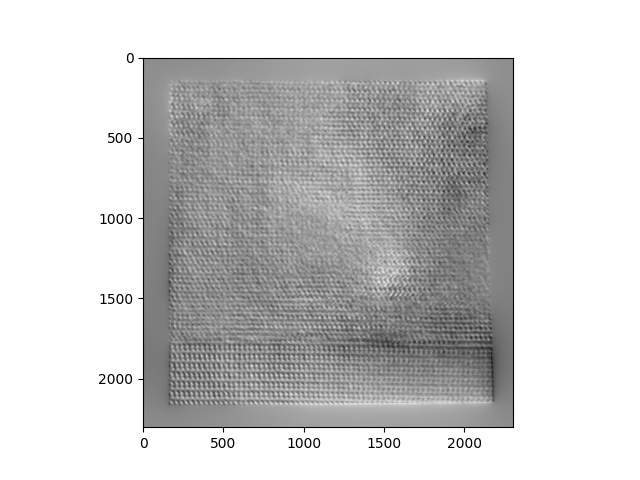

In [45]:
plt.clf()
plt.imshow(dpc.iDPC, cmap="binary_r")
plt.show()

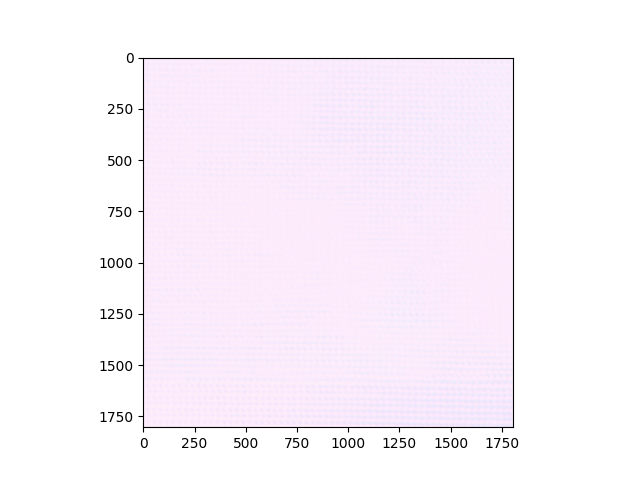

In [37]:
plt.clf()
dpc.phaseplot()
plt.show()

In [42]:
graphical.gui_savetiff(dpc.iDPC)
graphical.gui_savetiff(dpc.dDPC)

In [47]:
# Crop HAADF identical
haadf_in = io.imread(graphical.gui_get_path(is_file=True), as_gray=True).astype("float64")
haadf = haadf_in[250:-250, 250:-250]
graphical.gui_savetiff(haadf)